## Importing Dependencies

#### The following notebook was written by AI22BTECH11005 and AI22BTECH11023, implementing CFL and DFL using bm22btech11004's code for preprocessing the PTBXL dataset and model architectures

In [7]:
import os
import pandas as pd
import numpy as np
import wfdb
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

## Path to PTBXL, please adjust accordingly

In [8]:
DATASET_PATH = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

## Loading the Data

In [9]:
df = pd.read_csv(os.path.join(DATASET_PATH, 'ptbxl_database.csv'), index_col='ecg_id')
scp_df = pd.read_csv(os.path.join(DATASET_PATH, 'scp_statements.csv'), index_col=0)
df['scp_codes'] = df['scp_codes'].apply(lambda x: eval(x))

In [10]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in scp_df.index:
            diagnostic_class = scp_df.loc[key]['diagnostic_class']
            if isinstance(diagnostic_class, str) and diagnostic_class.strip():
                tmp.append(diagnostic_class)
    return list(set(tmp))


In [11]:
df['diagnostic_superclass'] = df['scp_codes'].apply(aggregate_diagnostic)

In [12]:
print(df['diagnostic_superclass'].head())
df

ecg_id
1    [NORM]
2    [NORM]
3    [NORM]
4    [NORM]
5    [NORM]
Name: diagnostic_superclass, dtype: object


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


In [13]:
df = df[df['diagnostic_superclass'].map(len) > 0].reset_index(drop=True)

In [14]:
print(df['diagnostic_superclass'].head(1000))


0           [NORM]
1           [NORM]
2           [NORM]
3           [NORM]
4           [NORM]
          ...     
995    [HYP, STTC]
996         [NORM]
997         [NORM]
998         [NORM]
999           [CD]
Name: diagnostic_superclass, Length: 1000, dtype: object


In [15]:
def aggregate_subdiagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in scp_df.index:
            diagnostic_subclass = scp_df.loc[key]['diagnostic_subclass']
            if isinstance(diagnostic_subclass, str) and diagnostic_subclass.strip():
                tmp.append(diagnostic_subclass)
    return list(set(tmp))

In [16]:
df['diagnostic_subclass'] = df['scp_codes'].apply(aggregate_subdiagnostic)

In [17]:
print(df['diagnostic_subclass'].head(1000))

0           [NORM]
1           [NORM]
2           [NORM]
3           [NORM]
4           [NORM]
          ...     
995    [LVH, STTC]
996         [NORM]
997         [NORM]
998         [NORM]
999        [CRBBB]
Name: diagnostic_subclass, Length: 1000, dtype: object


## Refining the data and End Pre-Processing

In [18]:
df['diagnostic_superclass'] = df['diagnostic_superclass'].apply(
    lambda lst: [x for x in lst if isinstance(x, str) and x.strip()]
)
df = df[df['diagnostic_superclass'].map(len) > 0].reset_index(drop=True)

In [19]:
df['diagnostic_subclass'] = df['diagnostic_subclass'].apply(
    lambda lst: [x for x in lst if isinstance(x, str) and x.strip()]
)
df = df[df['diagnostic_subclass'].map(len) > 0].reset_index(drop=True)

In [20]:
scp_df = pd.read_csv(
    os.path.join(DATASET_PATH, 'scp_statements.csv'),
    index_col=0
)
print("Unique diagnostic classes:")
print(scp_df['diagnostic_class'].unique())

Unique diagnostic classes:
['STTC' 'NORM' 'MI' 'HYP' 'CD' nan]


In [21]:
print(df['diagnostic_superclass'].head())

0    [NORM]
1    [NORM]
2    [NORM]
3    [NORM]
4    [NORM]
Name: diagnostic_superclass, dtype: object


In [22]:
print(df['diagnostic_subclass'].head(1000))

0           [NORM]
1           [NORM]
2           [NORM]
3           [NORM]
4           [NORM]
          ...     
995    [LVH, STTC]
996         [NORM]
997         [NORM]
998         [NORM]
999        [CRBBB]
Name: diagnostic_subclass, Length: 1000, dtype: object


## Setting up a Multilabel Binarizer

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer
all_labels = df['diagnostic_superclass'].tolist() + df['diagnostic_subclass'].tolist()

mlb = MultiLabelBinarizer()
mlb.fit(all_labels)
labels = mlb.transform(df['diagnostic_superclass'])  # For initial labeling

print("All Classes:")
print(mlb.classes_)
print(labels)
print(labels.shape)

All Classes:
['AMI' 'CD' 'CLBBB' 'CRBBB' 'HYP' 'ILBBB' 'IMI' 'IRBBB' 'ISCA' 'ISCI'
 'ISC_' 'IVCD' 'LAFB/LPFB' 'LAO/LAE' 'LMI' 'LVH' 'MI' 'NORM' 'NST_' 'PMI'
 'RAO/RAE' 'RVH' 'SEHYP' 'STTC' 'WPW' '_AVB']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(21388, 26)


In [24]:
df['filename'] = df['filename_hr'].apply(lambda x: os.path.join(DATASET_PATH, x))

In [25]:
df.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass,diagnostic_subclass,filename
0,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM],[NORM],ptb-xl-a-large-publicly-available-electrocardi...
1,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM],[NORM],ptb-xl-a-large-publicly-available-electrocardi...
2,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM],[NORM],ptb-xl-a-large-publicly-available-electrocardi...
3,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM],[NORM],ptb-xl-a-large-publicly-available-electrocardi...
4,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM],[NORM],ptb-xl-a-large-publicly-available-electrocardi...


## Continued Preprocessing of Signals (Plus Downsampling to reduce Computations for testing)

In [26]:
def load_signals(df):
    signals = []
    count = 0
    for filename in df['filename']:
        signal, fields = wfdb.rdsamp(filename)
        signals.append(signal)
        count+=1
        if(count > 2000):
            break
    return np.array(signals)
X = load_signals(df)
def downsample_signals(X, target_length=1000):
    X_downsampled = signal.resample(X, target_length, axis=1)
    return X_downsampled

X = downsample_signals(X, target_length=1000)

def normalize_signals(X):
    N, L, C = X.shape
    X_normalized = np.zeros_like(X)
    for i in range(N):
        scaler = StandardScaler()
        X_normalized[i] = scaler.fit_transform(X[i])
    return X_normalized

X = normalize_signals(X)
print(len(X))

2001


## Splitting Train and Test

In [32]:
df = df.reset_index()
train_indices = df[df.strat_fold < 10].index
test_indices = df[df.strat_fold == 10].index

v = X.shape[0]
train_indices = [i for i in train_indices if i < v]
test_indices = [i for i in test_indices if i < v]

X_train = X[train_indices]
X_test = X[test_indices]

y_train = labels[train_indices]
y_test = labels[test_indices]

In [41]:
# print(X_train.shape)

(2001, 1000, 12)


## Resnet

In [36]:
input_shape = X.shape[1:]
num_classes = len(mlb.classes_)
def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    def res_block(x, filters, kernel_size=3, stride=1):
        shortcut = x
        x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv1D(filters, kernel_size, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
            shortcut = layers.Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.add([x, shortcut])
        x = layers.ReLU()(x)
        return x

    x = res_block(x, 64)
    x = res_block(x, 64)
    
    x = res_block(x, 128, stride=2)
    x = res_block(x, 128)
    
    x = res_block(x, 256, stride=2)
    x = res_block(x, 256)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

def build_model():
    return build_resnet(input_shape, num_classes)

In [37]:
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [160]:
batch_size = 32
epochs = 10

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test)
)


Epoch 1/10
55/55 [==============================] - 5s 36ms/step - loss: 0.1360 - accuracy: 0.5749 - val_loss: 0.0955 - val_accuracy: 0.5494
Epoch 2/10
55/55 [==============================] - 1s 27ms/step - loss: 0.0638 - accuracy: 0.6711 - val_loss: 0.0793 - val_accuracy: 0.5850
Epoch 3/10
55/55 [==============================] - 1s 26ms/step - loss: 0.0593 - accuracy: 0.6899 - val_loss: 0.0748 - val_accuracy: 0.6285
Epoch 4/10
55/55 [==============================] - 1s 26ms/step - loss: 0.0562 - accuracy: 0.6997 - val_loss: 0.0710 - val_accuracy: 0.6403
Epoch 5/10
55/55 [==============================] - 1s 26ms/step - loss: 0.0535 - accuracy: 0.7237 - val_loss: 0.0721 - val_accuracy: 0.6364
Epoch 6/10
55/55 [==============================] - 1s 26ms/step - loss: 0.0524 - accuracy: 0.7248 - val_loss: 0.0750 - val_accuracy: 0.6047
Epoch 7/10
55/55 [==============================] - 1s 26ms/step - loss: 0.0473 - accuracy: 0.7351 - val_loss: 0.0706 - val_accuracy: 0.6759
Epoch 8/10
55

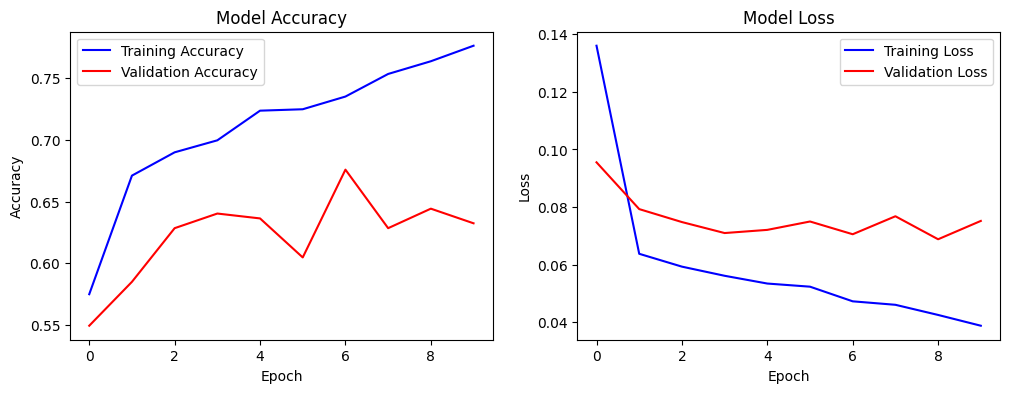

In [161]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [38]:
import numpy as np
from sklearn.utils import shuffle

# Assuming X_train and Y_train are numpy arrays
# and you want to partition them into 5 users

# Shuffle the data to ensure IID
X_train_t, Y_train_t = shuffle(X_train, y_train, random_state=42)
# print(len(X_train))
# Number of users
n_users = 5

# Split the data into n_users parts
X_split = np.array_split(X_train_t, n_users)
Y_split = np.array_split(Y_train_t, n_users)

# Now, X_split and Y_split contain the training data for each user
# Example: data for user 1 will be X_split[0] and Y_split[0]
print(X_train.shape)
for i in range(n_users):
    print(f"User {i+1} - X size: {len(X_split[i])}, Y size: {len(Y_split[i])}")

(1748, 1000, 12)
User 1 - X size: 350, Y size: 350
User 2 - X size: 350, Y size: 350
User 3 - X size: 350, Y size: 350
User 4 - X size: 349, Y size: 349
User 5 - X size: 349, Y size: 349


--------------------------------------------------------------------------------------------------------------------------------
ROUND NUMBER: 0
--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------
CLIENT ID: 1
--------------------------------------------------------------------------------------------------------------------------------
Epoch 1/10
11/11 [==============================] - 4s 95ms/step - loss: 0.2915 - accuracy: 0.5400 - val_loss: 0.1454 - val_accuracy: 0.5257
Epoch 2/10
11/11 [==============================] - 0s 33ms/step - loss: 0.0781 - accuracy: 0.6229 - val_loss: 0.1410 - val_accuracy: 0.1067
Epoch 3/10
11/11 [==============================] - 0s 34ms/step - loss: 0.0583 - accuracy: 0.6829 - val_loss: 0.1145 - val_accuracy: 0.3241
Epoch 4/10
11/11 [==============

Text(0.5, 1.0, 'Training graph for resnet')

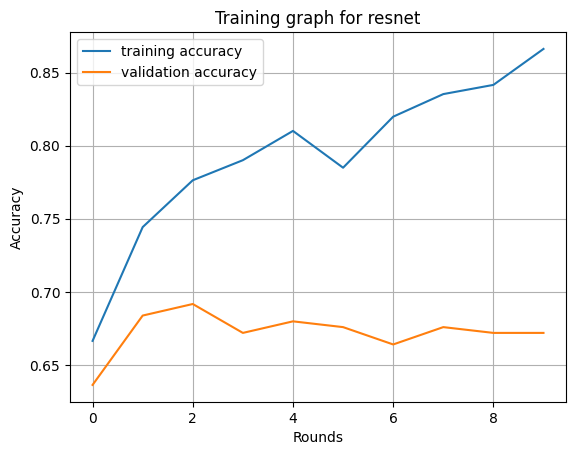

In [40]:
#Federated Learning on ResNet
global_model = build_model()
global_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
w = global_model.get_weights()

model_list = []
for user in range(n_users):
    m = build_model()
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_list.append(m)

num_samples = 5
tr_acc = []
val_acc = []
counts = np.zeros(n_users)
for epoch in range(10):
    print("--------------------------------------------------------------------------------------------------------------------------------")
    print("ROUND NUMBER:", epoch)
    print("--------------------------------------------------------------------------------------------------------------------------------")
    w_old = global_model.get_weights()
    w_new = []
    sample_user_list = np.random.choice(n_users, num_samples, replace = False)
    for i in w_old:
        w_new.append(np.zeros(i.shape))
    N = 0
    for user in sample_user_list:
        N += X_split[user].shape[0]
    for user in sample_user_list:
        print("--------------------------------------------------------------------------------------------------------------------------------")
        print("CLIENT ID:", user)
        print("--------------------------------------------------------------------------------------------------------------------------------")
        model_list[user].set_weights(w_old)
        counts[user]+=1
        batch_size = 32
        epochs = 10
        history = model_list[user].fit(
            X_split[user], Y_split[user],
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test)
        )
        print(history)
        with tf.device('/GPU:0'):
            w_k = model_list[user].get_weights()
        m = X_split[user].shape[0]
        for i in range(len(w_old)):
            w_new[i] += m / N * (w_k[i])
    with tf.device('/GPU:0'):
        global_model.set_weights(w_new)
    tr_acc.append(global_model.evaluate(X_train, y_train, batch_size = 128)[1])
    val_acc.append(global_model.evaluate(X_test, y_test, batch_size = 128)[1])
print("Number of times each client was chosen")
print(counts)
plt.plot(range(10), tr_acc, label = 'training accuracy')
plt.plot(range(10), val_acc, label = 'validation accuracy')
plt.grid()
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Training graph for resnet')

In [155]:
results = global_model.evaluate(X_test, y_test, batch_size=128)
results = global_model.evaluate(X_train, y_train, batch_size=128)

14/14 [==============================] - 0s 22ms/step - loss: 0.0319 - accuracy: 0.8244


## CNN

In [34]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    return model
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]
model = build_cnn(input_shape, num_classes)


In [23]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# batch_size = 32
# epochs = 10
# history = model.fit(
#     X_train, y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(X_test, y_test)
# )

In [30]:
import numpy as np
from sklearn.utils import shuffle

# Assuming X_train and Y_train are numpy arrays
# and you want to partition them into 5 users

# Shuffle the data to ensure IID
X_train_t, Y_train_t = shuffle(X_train, y_train, random_state=42)
# print(len(X_train))
# Number of users
n_users = 5

# Split the data into n_users parts
X_split = np.array_split(X_train_t, n_users)
Y_split = np.array_split(Y_train_t, n_users)

# Now, X_split and Y_split contain the training data for each user
# Example: data for user 1 will be X_split[0] and Y_split[0]
print(X_train.shape)
for i in range(n_users):
    print(f"User {i+1} - X size: {len(X_split[i])}, Y size: {len(Y_split[i])}")

(1748, 1000, 12)
User 1 - X size: 350, Y size: 350
User 2 - X size: 350, Y size: 350
User 3 - X size: 350, Y size: 350
User 4 - X size: 349, Y size: 349
User 5 - X size: 349, Y size: 349


In [25]:
print(X_train)

[[[ 0.10166333  0.60091201  0.6809136  ...  0.58449898  0.50905397
    0.24840473]
  [-1.30089975 -0.89221565  1.15404935 ... -0.51905149 -0.58673054
   -0.96992044]
  [-0.96982806 -0.39576622  1.25214836 ... -0.14282743 -0.22482265
   -0.56582458]
  ...
  [ 1.97986558  2.45713365 -0.15765983 ...  2.01610065  1.93899158
    1.7927966 ]
  [ 1.72694509  2.24904633  0.01599139 ...  1.84510409  1.7631232
    1.6175444 ]
  [ 2.13760216  2.61534552 -0.2245183  ...  2.13901363  2.06209909
    1.92658628]]

 [[-0.20325111  0.34150827  0.57910277 ...  0.03124785 -0.20398479
   -0.06893784]
  [-0.10026547  0.51937659  0.73646907 ...  0.68400818  0.34209431
    0.42750328]
  [-0.37608448  0.3826103   0.75167372 ...  0.34376236  0.01787626
    0.10799936]
  ...
  [-0.40735832  0.05819873  0.35450017 ... -0.82843175 -0.93202934
   -0.76282307]
  [-0.37796627  0.10001177  0.38843888 ... -0.7279541  -0.84251513
   -0.67110584]
  [-0.42547586  0.03349153  0.33511247 ... -0.90310989 -0.99444422
   -0.8

--------------------------------------------------------------------------------------------------------------------------------
ROUND NUMBER: 0
--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------
CLIENT ID: 1
--------------------------------------------------------------------------------------------------------------------------------
Epoch 1/10
11/11 [==============================] - 2s 57ms/step - loss: 0.7548 - accuracy: 0.1514 - val_loss: 0.2648 - val_accuracy: 0.4348
Epoch 2/10
11/11 [==============================] - 0s 22ms/step - loss: 0.4792 - accuracy: 0.2800 - val_loss: 0.4686 - val_accuracy: 0.4466
Epoch 3/10
11/11 [==============================] - 0s 23ms/step - loss: 0.3514 - accuracy: 0.4257 - val_loss: 0.5920 - val_accuracy: 0.2846
Epoch 4/10
11/11 [==============

Text(0.5, 1.0, 'Training graph for CNN')

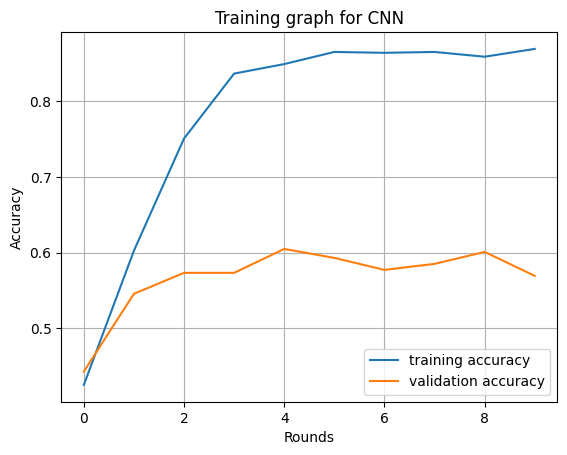

In [35]:
#Federated Learning on CNN
global_model = build_cnn(input_shape, num_classes)
global_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
w = global_model.get_weights()

model_list = []
for user in range(n_users):
    m = build_cnn(input_shape, num_classes)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_list.append(m)

num_samples = 5
tr_acc = []
val_acc = []
counts = np.zeros(n_users)
for epoch in range(10):
    print("--------------------------------------------------------------------------------------------------------------------------------")
    print("ROUND NUMBER:", epoch)
    print("--------------------------------------------------------------------------------------------------------------------------------")
    w_old = global_model.get_weights()
    w_new = []
    sample_user_list = np.random.choice(n_users, num_samples, replace = False)
    for i in w_old:
        w_new.append(np.zeros(i.shape))
    N = 0
    for user in sample_user_list:
        N += X_split[user].shape[0]
    for user in sample_user_list:
        print("--------------------------------------------------------------------------------------------------------------------------------")
        print("CLIENT ID:", user)
        print("--------------------------------------------------------------------------------------------------------------------------------")
        model_list[user].set_weights(w_old)
        counts[user]+=1
        batch_size = 32
        epochs = 10
        history = model_list[user].fit(
            X_split[user], Y_split[user],
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test)
        )
        print(history)
        with tf.device('/GPU:0'):
            w_k = model_list[user].get_weights()
        m = X_split[user].shape[0]
        for i in range(len(w_old)):
            w_new[i] += m / N * (w_k[i])
    with tf.device('/GPU:0'):
        global_model.set_weights(w_new)
    tr_acc.append(global_model.evaluate(X_train, y_train, batch_size = 128)[1])
    val_acc.append(global_model.evaluate(X_test, y_test, batch_size = 128)[1])
print("Number of times each client was chosen")
print(counts)
plt.plot(range(10), tr_acc, label = 'training accuracy')
plt.plot(range(10), val_acc, label = 'validation accuracy')
plt.grid()
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Training graph for CNN')

In [167]:
results = global_model.evaluate(X_test, y_test, batch_size=128)
results = global_model.evaluate(X_train, y_train, batch_size=128)

14/14 [==============================] - 0s 16ms/step - loss: 0.0061 - accuracy: 0.8759


In [26]:
# fully connected topology
# Initialize models for all clients
model_list = []
for user in range(n_users):
    m = build_cnn(input_shape, num_classes)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_list.append(m)

# Calculate dataset sizes for weighted aggregation
data_sizes = [X_split[user].shape[0] for user in range(n_users)]
total_data_size = sum(data_sizes)
weights = [data_size / total_data_size for data_size in data_sizes]

# Training loop
for epoch in range(10):
    print("--------------------------------------------------------------------------------------------------------------------------------")
    print(f"ROUND NUMBER: {epoch}")
    print("--------------------------------------------------------------------------------------------------------------------------------")

    # Each client trains locally
    weights_list = []
    for user in range(n_users):
        print(f"Client {user} local training...")
        batch_size = 32
        local_epochs = 10

        # Train the client model
        history = model_list[user].fit(
            X_split[user], Y_split[user],
            batch_size=batch_size,
            epochs=local_epochs,
            validation_data=(X_test, y_test)
        )
        print(history)

        # Save updated weights
        with tf.device('/GPU:0'):
            weights_list.append(model_list[user].get_weights())

    # Peer-to-peer communication: fully connected weighted aggregation
    for user in range(n_users):
        # Aggregate weights using weighted averaging
        aggregated_weights = [np.zeros_like(w) for w in weights_list[user]]
        for neighbor in range(n_users):
            neighbor_weights = weights_list[neighbor]
            for i in range(len(aggregated_weights)):
                # Weighted contribution based on data size
                aggregated_weights[i] += weights[neighbor] * neighbor_weights[i]

        # Update client's weights with the aggregated weights
        model_list[user].set_weights(aggregated_weights)

    # Optionally evaluate models on global validation data
    for user in range(n_users):
        val_acc = model_list[user].evaluate(X_test, y_test, batch_size=128)[1]
        print(f"Client {user} validation accuracy: {val_acc}")

--------------------------------------------------------------------------------------------------------------------------------
ROUND NUMBER: 0
--------------------------------------------------------------------------------------------------------------------------------
Client 0 local training...
Epoch 1/10
11/11 [==============================] - 18s 166ms/step - loss: 0.7412 - accuracy: 0.1400 - val_loss: 0.2715 - val_accuracy: 0.5217
Epoch 2/10
11/11 [==============================] - 1s 90ms/step - loss: 0.4978 - accuracy: 0.2771 - val_loss: 0.3502 - val_accuracy: 0.4269
Epoch 3/10
11/11 [==============================] - 1s 54ms/step - loss: 0.3589 - accuracy: 0.3543 - val_loss: 0.2993 - val_accuracy: 0.4585
Epoch 4/10
11/11 [==============================] - 1s 88ms/step - loss: 0.2745 - accuracy: 0.4314 - val_loss: 0.1995 - val_accuracy: 0.5020
Epoch 5/10
11/11 [==============================] - 1s 75ms/step - loss: 0.2329 - accuracy: 0.4857 - val_loss: 0.1603 - val_accuracy:

In [27]:
#ring topology
import numpy as np

# Build a single model to generate shared random weights
temp_model = build_cnn(input_shape, num_classes)
shared_weights = temp_model.get_weights()  # Extract the random weights
del temp_model  # Remove the temporary model to save memory

# Initialize models for all clients with shared weights
model_list = []
for user in range(n_users):
    m = build_cnn(input_shape, num_classes)
    m.set_weights(shared_weights)  # Assign shared weights to each client
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_list.append(m)

# Calculate dataset sizes for weighted aggregation
data_sizes = [X_split[user].shape[0] for user in range(n_users)]
total_data_size = sum(data_sizes)
weights = [data_size / total_data_size for data_size in data_sizes]

# Training loop
for epoch in range(10):
    print("--------------------------------------------------------------------------------------------------------------------------------")
    print(f"ROUND NUMBER: {epoch}")
    print("--------------------------------------------------------------------------------------------------------------------------------")

    # Each client trains locally
    weights_list = []
    for user in range(n_users):
        print(f"Client {user} local training...")
        batch_size = 32
        local_epochs = 10

        # Train the client model
        history = model_list[user].fit(
            X_split[user], Y_split[user],
            batch_size=batch_size,
            epochs=local_epochs,
            validation_data=(X_test, y_test)
        )
        print(history)

        # Save updated weights
        weights_list.append(model_list[user].get_weights())

    # Peer-to-peer communication: ring topology
    aggregated_weights = []
    for user in range(n_users):
        # Define left and right neighbors
        left_neighbor = (user - 1) % n_users
        right_neighbor = (user + 1) % n_users

        # Initialize aggregated weights for the current user
        peer_weights = [np.zeros_like(w) for w in weights_list[user]]
        total_size = data_sizes[user] + data_sizes[left_neighbor] + data_sizes[right_neighbor]

        # Aggregate weights from self and neighbors
        neighbors = [user, left_neighbor, right_neighbor]
        for neighbor in neighbors:
            weight_factor = data_sizes[neighbor] / total_size
            for i in range(len(peer_weights)):
                peer_weights[i] += weight_factor * weights_list[neighbor][i]

        aggregated_weights.append(peer_weights)

    # Update each client's weights with their aggregated weights
    for user in range(n_users):
        model_list[user].set_weights(aggregated_weights[user])

    # Optionally evaluate models on global validation data
    for user in range(n_users):
        val_acc = model_list[user].evaluate(X_test, y_test, batch_size=128)[1]
        print(f"Client {user} validation accuracy: {val_acc}")


--------------------------------------------------------------------------------------------------------------------------------
ROUND NUMBER: 0
--------------------------------------------------------------------------------------------------------------------------------
Client 0 local training...
Epoch 1/10
11/11 [==============================] - 2s 69ms/step - loss: 0.6134 - accuracy: 0.1686 - val_loss: 0.2529 - val_accuracy: 0.5336
Epoch 2/10
11/11 [==============================] - 0s 37ms/step - loss: 0.4524 - accuracy: 0.3943 - val_loss: 0.3027 - val_accuracy: 0.5099
Epoch 3/10
11/11 [==============================] - 1s 56ms/step - loss: 0.3149 - accuracy: 0.4286 - val_loss: 0.2757 - val_accuracy: 0.4941
Epoch 4/10
11/11 [==============================] - 1s 66ms/step - loss: 0.2389 - accuracy: 0.5029 - val_loss: 0.2571 - val_accuracy: 0.5296
Epoch 5/10
11/11 [==============================] - 1s 60ms/step - loss: 0.2219 - accuracy: 0.5543 - val_loss: 0.2973 - val_accuracy: 0

In [31]:
# fully connected topology
# Initialize models for all clients
model_list = []
for user in range(n_users):
    m = build_cnn(input_shape, num_classes)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_list.append(m)

# Calculate dataset sizes for weighted aggregation
data_sizes = [X_split[user].shape[0] for user in range(n_users)]
total_data_size = sum(data_sizes)
weights = [data_size / total_data_size for data_size in data_sizes]

# Training loop
for epoch in range(10):
    print("--------------------------------------------------------------------------------------------------------------------------------")
    print(f"ROUND NUMBER: {epoch}")
    print("--------------------------------------------------------------------------------------------------------------------------------")

    # Each client trains locally
    weights_list = []
    for user in range(n_users):
        print(f"Client {user} local training...")
        batch_size = 32
        local_epochs = 10

        # Train the client model
        history = model_list[user].fit(
            X_split[user], Y_split[user],
            batch_size=batch_size,
            epochs=local_epochs,
            validation_data=(X_test, y_test)
        )
        print(history)

        # Save updated weights
        with tf.device('/GPU:0'):
            weights_list.append(model_list[user].get_weights())

    # Peer-to-peer communication: fully connected weighted aggregation
    for user in range(n_users):
        # Aggregate weights using weighted averaging
        aggregated_weights = [np.zeros_like(w) for w in weights_list[user]]
        for neighbor in range(n_users):
            neighbor_weights = weights_list[neighbor]
            for i in range(len(aggregated_weights)):
                # Weighted contribution based on data size
                aggregated_weights[i] += weights[neighbor] * neighbor_weights[i]

        # Update client's weights with the aggregated weights
        model_list[user].set_weights(aggregated_weights)

    # Optionally evaluate models on global validation data
    for user in range(n_users):
        val_acc = model_list[user].evaluate(X_test, y_test, batch_size=128)[1]
        tr_acc= model_list[user].evaluate(X_train, y_train, batch_size=128)[1]
        print(f"Client {user} validation accuracy: {val_acc}")
        print(f"Client {user} Training accuracy: {tr_acc}")

--------------------------------------------------------------------------------------------------------------------------------
ROUND NUMBER: 0
--------------------------------------------------------------------------------------------------------------------------------
Client 0 local training...
Epoch 1/10
11/11 [==============================] - 8s 62ms/step - loss: 0.6250 - accuracy: 0.2000 - val_loss: 0.1683 - val_accuracy: 0.5296
Epoch 2/10
11/11 [==============================] - 0s 21ms/step - loss: 0.4336 - accuracy: 0.4143 - val_loss: 0.2340 - val_accuracy: 0.5296
Epoch 3/10
11/11 [==============================] - 0s 22ms/step - loss: 0.2980 - accuracy: 0.4371 - val_loss: 0.2013 - val_accuracy: 0.5375
Epoch 4/10
11/11 [==============================] - 0s 23ms/step - loss: 0.2331 - accuracy: 0.4914 - val_loss: 0.1432 - val_accuracy: 0.5296
Epoch 5/10
11/11 [==============================] - 0s 22ms/step - loss: 0.1956 - accuracy: 0.5800 - val_loss: 0.1259 - val_accuracy: 0